<br/>

$$ \huge{\underline{\textbf{ SARSA }}} $$

<br/>

<img src="assets/0604_Sarsa.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 6.4 </center>

<br/>

In [96]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            if done: break
                
    return Q

In [71]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

<img src="assets/0604.gridworld.png"/>

In [201]:
class WindyGridworld:
    def __init__(self):
        self.act_space = [0, 1, 2, 3]  # LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self.reset()
        
    def reset(self):
        self._x, self._y = 0, 3      # agent initial position
        return (0, 3)
        
    def step(self, action):
        # actions: LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3
        self._x, self._y = self.transition(self._x, self._y, action)
        
        if self._x == 7 and self._y == 3:        # GOAL reached
            return (self._x, self._y), -1, True  # observation, reward, done
        return (self._x, self._y), -1, False     # obs, rew, done 
        
    def transition(x, y, action):  # omnit 'self' so we can call form outside
        """Perform transition from [x,y] given action"""
        if x in [3,4,5,8]:  y += 1  # windy
        if x in [6,7]:      y += 2  # woo, very windy
        
        if action == 0:    x -= 1   # left
        elif action == 1:  y -= 1   # down
        elif action == 2:  x += 1   # right
        elif action == 3:  y += 1   # up
        else: raise ValueError('Action must be in [0,1,2,3]')
            
        x = np.clip(x, 0, 9)   # x range is [0..9]
        y = np.clip(y, 0, 6)   # y range is [0..6]
        return x, y

In [92]:
env = WindyGridworld()

In [236]:
Q = sarsa(env, 100000, gamma=1., alpha=.5, eps=.1)

In [238]:
def plot_windy(Q, hide_policy=False, savepath=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlim(-.5, 9.5)
    ax.set_ylim(-.5, 6.5)
    ax.set_yticks([])
    ax.set_xticks(     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.set_xticklabels([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

    ax.text(0, 3, 'S', fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax.text(7, 3, 'G', fontsize=18, horizontalalignment='center', verticalalignment='center')
    
    for x in range(10):
        for y in range(7):
            ax.add_patch(
                patches.Rectangle([x-0.5, y-0.5], 1, 1, fill=False))

            if not hide_policy:
                A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])  # pick best action
                if A_star == 3: # up
                    ax.arrow(x, y, 0,  .1, head_width=0.2, head_length=0.2, color='gray', alpha=.2)
                elif A_star == 1: # down
                    ax.arrow(x, y, 0, -.1, head_width=0.2, head_length=0.2, color='gray', alpha=.2)
                elif A_star == 0: # left
                    ax.arrow(x, y, -.1, 0, head_width=0.2, head_length=0.2, color='gray', alpha=.2)
                elif A_star == 2: # right
                    ax.arrow(x, y,  .1, 0, head_width=0.2, head_length=0.2, color='gray', alpha=.2)

    x, y = 0, 3  # agent starting position
    for _ in range(100):  # just in case policy is loopy
        A_star = np.argmax([Q[(x,y),a] for a in [0, 1, 2, 3]])  # pick best action
        x_, y_ = WindyGridworld.transition(x, y, A_star)    
        ax.plot([x, x_], [y, y_], color='blue', alpha=1.)
        x, y = x_, y_
        if x == 7 and y == 3:  break

    plt.tight_layout()
    
    if savepath is not None:
        plt.savefig(savepath)
    
    plt.show()

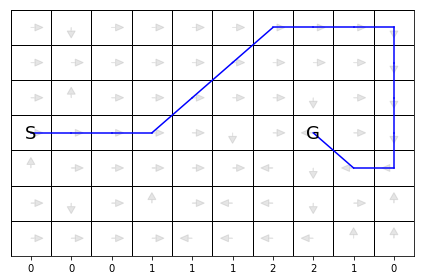

In [240]:
plot_windy(Q)

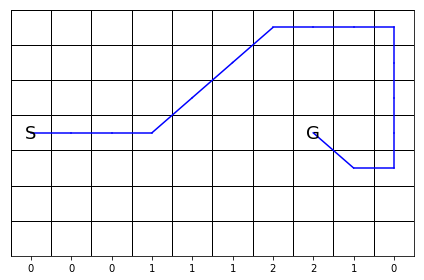

In [239]:
# plot_windy(Q, hide_policy=True, savepath='assets/fig_0604_path.png')

Keep track of time steps and episodes

In [248]:
def sarsa_ext(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
        
    hist_ep = []   # one entry per time step
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    
    for current_episode in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            S, A = S_, A_
            
            hist_ep.append(current_episode)
            if len(hist_ep) >= 8000:
                return Q, hist_ep
            
            if done: break
                
    return Q, hist_ep

In [249]:
Q, hist_ep = sarsa_ext(env, 8000, gamma=1., alpha=.5, eps=.1)

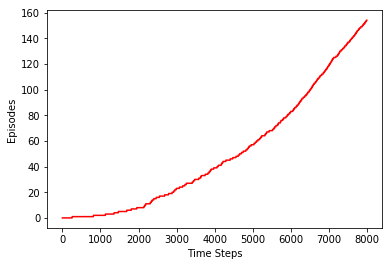

In [253]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(hist_ep, color='red')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Episodes')

plt.savefig('assets/fig_0604_ep.png')
plt.show()